In [1]:
# Imports
import sys,os
#sys.path.append(os.path.join(sys.path[0],'lib/'))
sys.path.append('./lib')
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf 
print('Tensorflow version: ',tf.__version__)
tf.test.gpu_device_name()
print(sys.path)

Tensorflow version:  1.15.2
['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/jbhayet/opt/repositories/devel/OF-PathPred/.venv/lib/python3.6/site-packages', '/home/jbhayet/opt/repositories/devel/OF-PathPred/.venv/lib/python3.6/site-packages/IPython/extensions', '/home/jbhayet/.ipython', './lib']


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10856188545090561780,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13364499204315451385
 physical_device_desc: "device: XLA_CPU device"]

In [3]:
from process_file import process_file_modif
from process_file import process_file_modif_varios
import batches_data
import model
import entrenamientoevaluacion
from entrenamientoevaluacion import evaluate
from interaction_optical_flow import OpticalFlowSimulator

In [7]:
# File of trajectories coordinates. Coordinates are in world frame
# dataset   = 'eth-hotel' 
#dataset    = 'eth-univ'
dataset   = 'ucy-zara01'
data_path = '../data1/'+dataset+'/mundo/mun_pos.csv'

# Parameters
class parameters:
    def __init__(self):
        # Maximum number of persons in a frame
        self.person_max = 42 # 8   # Univ: 42  Hotel: 28
        # Observation length (trajlet size)
        self.obs_len    = 8
        # Prediction length
        self.pred_len   = 12
        # Flag to consider social interactions
        self.add_social = True
        # Number of key points
        self.kp_num     = 18
        # Key point flag
        self.add_kp     = False
     

In [8]:
# Load the default parameters
arguments = parameters()

# Process eth_hotel data
# data = process_file_modif(hotel_pix_path, arguments, ',')

# Process eth_univ data
data = process_file_modif(data_path, arguments, ',')

[INF] Sequence length:  20
[INF] Number of considered subsequences:  872
Total number of examples
2356


In [9]:
# Should be nSamples x sequenceLength x nPersonsMax x PersonDescriptionSize 
print(data['obs_person'].shape) 
print(data['obs_person'][0])

(2356, 8, 42, 3)
[[[ 1.        13.448721   3.9378867]
  [ 2.        13.343488   4.439072 ]
  [ 3.        11.912325   4.439072 ]
  ...
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]]

 [[ 1.        12.935185   3.9378867]
  [ 2.        12.825323   4.430003 ]
  [ 3.        11.504654   4.513534 ]
  ...
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]]

 [[ 1.        12.421651   3.9378867]
  [ 2.        12.307368   4.4206953]
  [ 3.        11.096773   4.5882344]
  ...
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]]

 ...

 [[ 1.        10.937241   4.037408 ]
  [ 2.        10.904829   4.526183 ]
  [ 3.         9.870813   4.74933  ]
  ...
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]]

 [[ 1.        10.467483   3.991824 ]
  [ 2.        10.438

# Optical flow

In [10]:
optical_flow_file = 'of_'+dataset+'.npy'

In [11]:
OFSimulator = OpticalFlowSimulator()
# Compute the optical flow generated by the neighbors
optical_flow, visible_neigbors = OFSimulator.compute_opticalflow_batch(data['obs_person'],data['key_idx'],data['obs_traj'],arguments.obs_len)
np.save(optical_flow_file,optical_flow)

# Load the optical flow

In [12]:
# Load the optical flow
optical_flow = np.load(optical_flow_file)
optical_flow.shape

(2356, 8, 64)

# Visualize some examples of optical flow

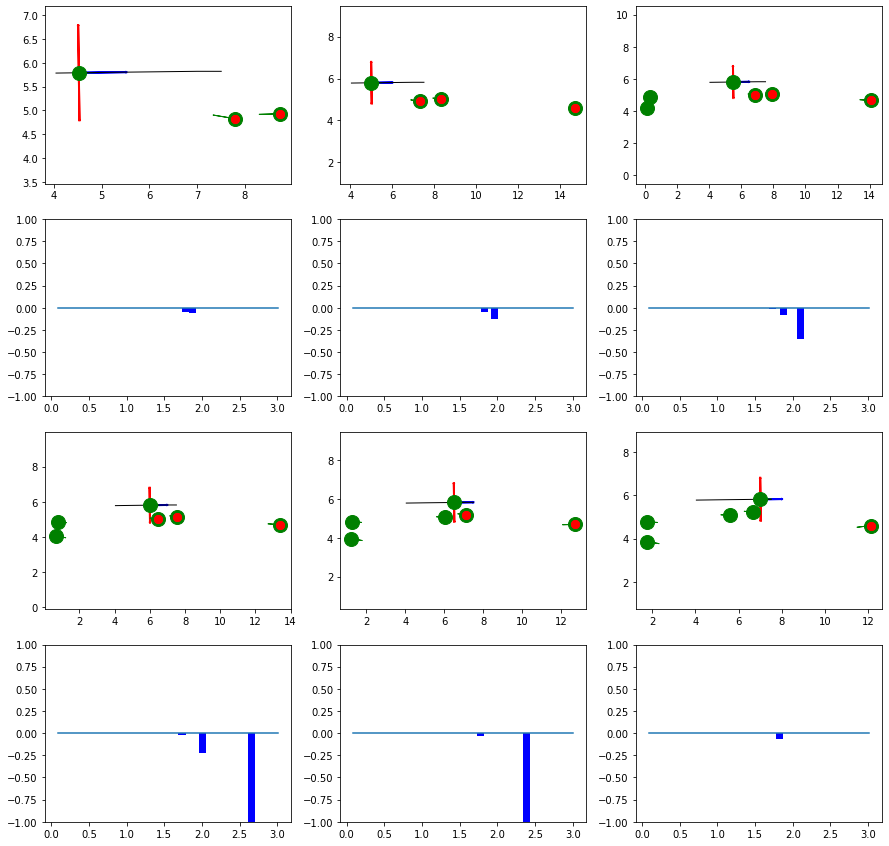

Saving...


In [13]:
import random
# Select a random sequence
idSample = random.sample(range(1,optical_flow.shape[0]), 1)

# Trajectory
traj_sample   = data["obs_traj"][idSample][0]
traj_neighbors= data['obs_person'][idSample][0]
traj_id       = data['key_idx'][idSample]
# Optical flow
optical_flow_sample,visible_neighbors_sample = OFSimulator.compute_opticalflow_seq(traj_id,traj_sample,traj_neighbors)
# Plot
OFSimulator.plot_flow(traj_sample,traj_neighbors,optical_flow_sample,visible_neighbors_sample)

# Optical flow is added to the data

In [14]:
data.update({"obs_flujo": optical_flow})

# Split the data

In [14]:
# Seed
import random
random.seed(0)

# Muestreamos aleatoriamente para separar datos de entrenamiento, validacion y prueba
training_pc  = 0.7 
test_pc      = 0.2

# Count how many data we have (sub-sequences of length 8, in pred_traj)
ndata      = len(data[list(data.keys())[2]])
idx        = random.sample(range(ndata), ndata)
training   = int(ndata*training_pc)
test       = int(ndata*test_pc)
validation = int(ndata-training-test)

# Indices for training
idx_train = idx[0:training]
# Indices for testing
idx_test  = idx[training:training+test]
# Indices for validation
idx_val   = idx[training+test:]

# Training set
training_data = {
     "obs_traj":      data["obs_traj"][idx_train],
     "obs_traj_rel":  data["obs_traj_rel"][idx_train],
     "pred_traj":     data["pred_traj"][idx_train],
     "pred_traj_rel": data["pred_traj_rel"][idx_train],
     "key_idx":       data["key_idx"][[idx_train]],
     "obs_flujo" :    data["obs_flujo"][idx_train],
     #"pred_kp": data_pets["pred_kp"][idx_train],
     #"obs_person": data_pets["obs_person"][idx_train],
}

# Test set
test_data = {
     "obs_traj":     data["obs_traj"][idx_test],
     "obs_traj_rel": data["obs_traj_rel"][idx_test],
     "pred_traj":    data["pred_traj"][idx_test],
     "pred_traj_rel":data["pred_traj_rel"][idx_test],
     "key_idx":      data["key_idx"][[idx_test]],
     "obs_flujo":    data["obs_flujo"][idx_test],
     #"pred_kp": data_pets["pred_kp"][idx_test],
     #"obs_person": data_pets["obs_person"][idx_test]
}

# Validation set
validation_data ={
     "obs_traj":     data["obs_traj"][idx_val],
     "obs_traj_rel": data["obs_traj_rel"][idx_val],
     "pred_traj":    data["pred_traj"][idx_val],
     "pred_traj_rel":data["pred_traj_rel"][idx_val],
     "key_idx":      data["key_idx"][[idx_val]],
     "obs_flujo":    data["obs_flujo"][idx_val],
     #"pred_kp": data_pets["pred_kp"][idx_val],
     #"obs_person": data_pets["obs_person"][idx_val],
}


print("training data: "+ str(len(training_data[list(training_data.keys())[0]])))
print("test data: "+ str(len(test_data[list(test_data.keys())[0]])))
print("validation data: "+ str(len(validation_data[list(validation_data.keys())[0]])))


training data: 1649
test data: 471
validation data: 236


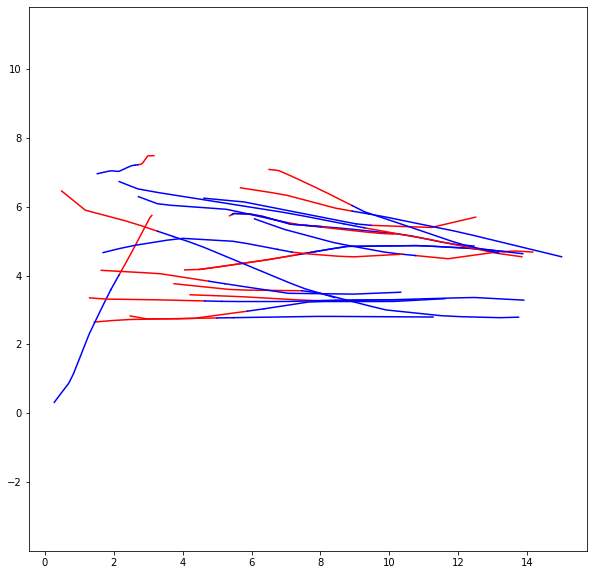

In [15]:
import matplotlib.pyplot as plt

# Plot ramdomly a subset of the training data (spatial data only)
nSamples = min(20,training)
samples  = random.sample(range(1,training), nSamples)
plt.subplots(1,1,figsize=(10,10))
plt.subplot(1,1,1)
plt.axis('equal')
# Plot some of the training data
for (o,p) in zip(training_data["obs_traj"][samples],training_data["pred_traj"][samples]):
    plt.plot(o[:,0],o[:,1],color='red')
    plt.plot([o[-1,0],p[0,0]],[o[-1,1],p[0,1]],color='blue')    
    plt.plot(p[:,0],p[:,1],color='blue')    

# Save the data to be used later

In [16]:
import pickle

# Training dataset
pickle_out = open('training_data_'+dataset+'.pickle',"wb")
pickle.dump(training, pickle_out, protocol=2)
pickle_out.close()

# Test dataset
pickle_out = open('test_data_'+dataset+'.pickle',"wb")
pickle.dump(test, pickle_out, protocol=2)
pickle_out.close()

# Validation dataset
pickle_out = open('validation_data_'+dataset+'.pickle',"wb")
pickle.dump(validation, pickle_out, protocol=2)
pickle_out.close()

# Model parameters

In [17]:
class model_parameters:
    def __init__(self, train_num_examples, add_kp = False, add_social = False):
        # -----------------
        # Observation/prediction lengths 
        self.obs_len  = 8
        self.pred_len = 12
        
        self.add_kp             = add_kp
        self.train_num_examples = train_num_examples
        self.add_social         = add_social
        # Key points
        self.kp_num = 18
        self.kp_size = 18
        #self.maxNumPed = 8
        #self.grid_size = 4
        #self.neighborhood_size = 32
        #self.dimensions = [768,576]
        #self.limites=[-15.88,11.56,-19.09,5.99]
        #self.bound=[0.7,0.5]
        # ------------------
        self.num_epochs = 100
        self.batch_size = 20 # batch size
        self.validate   = 300
        self.P          = 2 # Dimension
        self.enc_hidden_size = 64 # el nombre lo dice
        self.dec_hidden_size = 64
        self.emb_size        = 64
        self.keep_prob      = 0.7 # dropout
        
        self.min_ped = 1
        self.seq_len = self.obs_len + self.pred_len
        self.reverse_xy = False
        
        self.activation_func = tf.nn.tanh
        self.activation_func1 = tf.nn.relu
        self.is_train = True
        self.is_test = False
        self.multi_decoder = False
        self.modelname = 'gphuctl'
        
        self.init_lr = 0.002 # 0.01
        self.learning_rate_decay = 0.85
        self.num_epoch_per_decay = 2.0
        self.optimizer = 'adam'
        self.emb_lr = 1.0
        #self.clip_gradient_norm = 10.0
        #Para cuando entreno y quiero guardar el mejor modelo
        self.load_best = True

# Training the model

In [18]:
import os 
from tqdm import tqdm
import tensorflow as tf
import math
import model
tf.reset_default_graph()

arguments = model_parameters(train_num_examples=len(training_data['obs_traj']),add_kp = False, add_social = True,)
model     = model.Model(arguments)

train_data = batches_data.Dataset(training_data,arguments)
val_data   = batches_data.Dataset(validation_data,arguments)

saver     = tf.train.Saver(max_to_keep = 2)
bestsaver = tf.train.Saver(max_to_keep = 2)


trainer = entrenamientoevaluacion.Trainer(model,arguments)
tester  = entrenamientoevaluacion.Tester(model, arguments)

# Global variables are initialized
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

increment_global_step_op = tf.assign(model.global_step, model.global_step+1)

val_perf  = []
loss      = -1
best      = {'ade':999999, 'fde':0, 'step':-1}
is_start  = True
num_steps = int(math.ceil(train_data.num_examples/float(arguments.batch_size)))
loss_list = []

# Epochs
for i in range(arguments.num_epochs):    
    # Cycle over batches
    for idx, batch in tqdm(train_data.get_batches(arguments.batch_size,num_steps = num_steps),total=num_steps):
        
        sess.run(increment_global_step_op)
        global_step = sess.run(model.global_step)

        # Evaluation on validation data
        if((global_step%arguments.validate==0) or (arguments.load_best and is_start)):
            checkpoint_path_model = os.path.join('models/'+dataset, 'model.ckpt')
            saver.save(sess,checkpoint_path_model , global_step = global_step)
            # Evaluation on th validation set
            results, traj_ver, traj_pred, traj_obs = evaluate(val_data, tester,sess,arguments)           
            if results["ade"]< best['ade']:
                best['ade'] = results["ade"]
                best['fde'] = results["fde"]
                best["step"]= global_step
                # Save the best model
                checkpoint_path_model_best = os.path.join('models/'+dataset, 'model_best.ckpt')
                bestsaver.save(sess,checkpoint_path_model_best,global_step = 0)
                finalperf = results
                val_perf.append((loss, results))
            is_start = False
        loss, train_op = trainer.step(sess, batch)
        loss_list.append(loss)
    
if((global_step % arguments.validate)!=0):
  checkpoint_path_model = os.path.join('models/'+dataset, 'model.ckpt')
  saver.save(sess,checkpoint_path_model , global_step = global_step)

print("best eval on val %s: %s at %s step y fde es %s " % ('ade', best['ade'], best["step"],best["fde"]))
       
    

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  0%|          | 0/83 [00:00<?, ?it/s]


AttributeError: module 'itertools' has no attribute 'izip_longest'

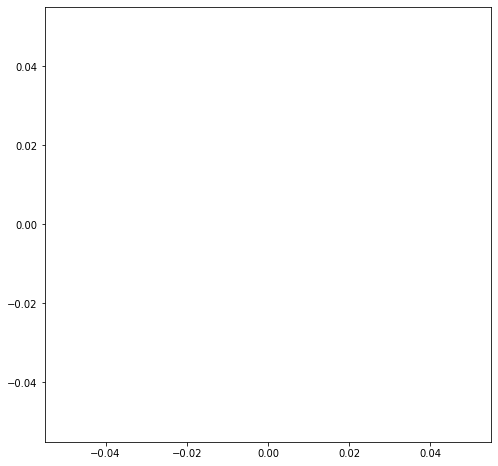

In [19]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
plt.plot(loss_list)
plt.show()

In [20]:
# Keep the last model
checkpoint_path_model = os.path.join('models/'+dataset, 'lastmodel.ckpt')
saver.save(sess,checkpoint_path_model , global_step = 0)

'models/ucy-zara01/lastmodel.ckpt-0'

# Restore the models

In [21]:
# Load the last model that was saved
path_model = 'models/'+dataset+'/lastmodel.ckpt-0'
saver.restore(sess=sess, save_path=path_model)


test_batches_data = batches_data.Dataset(test_data, arguments)
results, traj_ver, traj_pred, traj_obs  = evaluate(test_batches_data, tester,sess,arguments)
print(results)

INFO:tensorflow:Restoring parameters from models/ucy-zara01/lastmodel.ckpt-0


  0%|          | 0/24 [00:00<?, ?it/s]


AttributeError: module 'itertools' has no attribute 'izip_longest'

[212, 388, 201, 83, 79, 348, 220, 196, 228, 424, 378, 369, 330, 384, 110, 130, 33, 359, 82, 466]


NameError: name 'traj_obs' is not defined

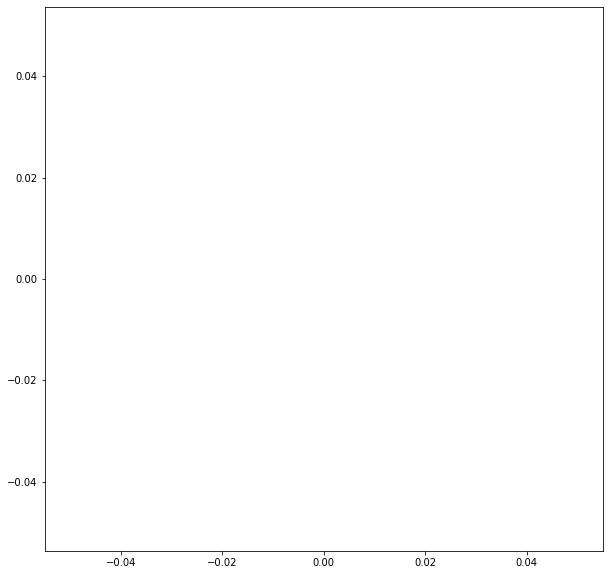

In [22]:
# Plot ramdomly a subset of the training data (spatial data only)
nSamples = min(20,test)
samples  = random.sample(range(1,test), nSamples)
plt.subplots(1,1,figsize=(10,10))
plt.subplot(1,1,1)
plt.axis('equal')
print(samples)
obs = [traj_obs[i] for i in samples] 
gt  = [traj_ver[i] for i in samples] 
pred= [traj_pred[i] for i in samples] 
# Plot some of the testing data and the predicted ones
for (g,o,p) in zip(gt,obs,pred):
    plt.plot(o[:,0],o[:,1],color='red')
    plt.plot([o[-1,0],g[0,0]],[o[-1,1],g[0,1]],color='blue')    
    plt.plot(g[:,0],g[:,1],color='blue')    
    plt.plot([o[-1,0],p[0,0]],[o[-1,1],p[0,1]],color='green')    
    plt.plot(p[:,0],p[:,1],color='green')    

In [28]:
# Best model
path_model = 'models/'+dataset+'/model_best.ckpt-0'
saver.restore(sess=sess, save_path=path_model)

test_batches_data = batches_data.Dataset(test_data, arguments)
results, traj_ver, traj_pred, traj_obs  = evaluate(test_batches_data, tester,sess,arguments)
print(results)

INFO:tensorflow:Restoring parameters from models/ucy-zara01/model_best.ckpt-0


100%|##########| 24/24 [00:00<00:00, 173.08it/s]

{'ade': 0.39286348, 'fde': 0.83841544}


[18, 170, 132, 389, 344, 242, 354, 128, 182, 241, 314, 331, 293, 26, 407, 136, 360, 375, 444, 337]


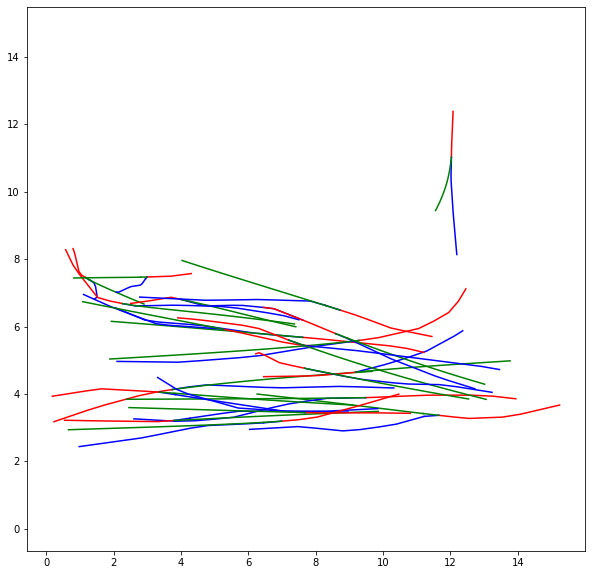

In [29]:
# Plot ramdomly a subset of the training data (spatial data only)
nSamples = min(20,test)
samples  = random.sample(range(1,test), nSamples)
plt.subplots(1,1,figsize=(10,10))
plt.subplot(1,1,1)
plt.axis('equal')
print(samples)
obs = [traj_obs[i] for i in samples] 
gt  = [traj_ver[i] for i in samples] 
pred= [traj_pred[i] for i in samples] 
# Plot some of the testing data and the predicted ones
for (g,o,p) in zip(gt,obs,pred):
    plt.plot(o[:,0],o[:,1],color='red')
    plt.plot([o[-1,0],g[0,0]],[o[-1,1],g[0,1]],color='blue')    
    plt.plot(g[:,0],g[:,1],color='blue')    
    plt.plot([o[-1,0],p[0,0]],[o[-1,1],p[0,1]],color='green')    
    plt.plot(p[:,0],p[:,1],color='green')    

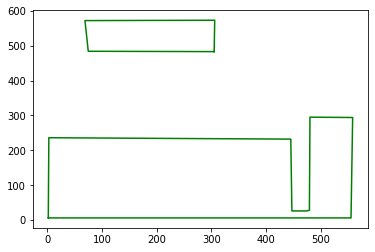

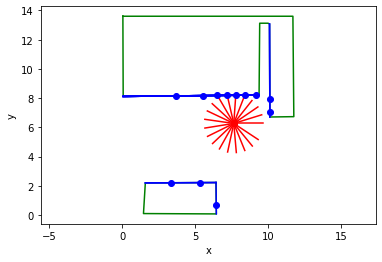

In [60]:
from obstacles import image_to_world_xy,raycast,generate_obstacle_polygons,load_image_obstacle_polygons, load_world_obstacle_polygons
import matplotlib.pyplot as plt

dataset_paths = "/home/jbhayet/opt/repositories/devel/OF-PathPred/data1/"
dataset_name = 'ucy-zara02/'

generate_obstacle_polygons(dataset_paths,dataset_name)
obstacles       = load_image_obstacle_polygons(dataset_paths,dataset_name)
obstacles_world = load_world_obstacle_polygons(dataset_paths,dataset_name)
# Draw the obstacles in the image frame
for obs in obstacles:
    pintar=plt.plot(obs[:,0],obs[:,1],"g-")
plt.show()

# Draw obstacles
for obst in obstacles_world:
    plt.plot(obst[:,0],obst[:,1],"g-")

xpos = np.random.normal(5.0,3.0)
ypos = np.random.normal(5.0,3.0)

for t in range(0,20):
    tpos = t*0.3
    c = np.cos(tpos)
    s = np.sin(tpos)
    plt.plot(xpos,ypos,"ro")
    plt.plot([xpos,xpos+2.0*c],[ypos,ypos+2.0*s],"r-")

    # Test for ray casting: first check if some polygons do intersect the ray.
    # If so, plot in red
    omin,imin,dmin,inters = raycast([xpos,ypos,tpos],obstacles_world)
    if imin>=0:
        plt.plot(obstacles_world[omin][imin:imin+2,0],obstacles_world[omin][imin:imin+2,1],"b-")
        plt.plot(inters[0],inters[1],"bo")

plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()